In [1]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pickle

In [2]:
'Year','CRSDepTime','ArrTime','CRSArrTime','CRSElapsedTime'

('Year', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'CRSElapsedTime')

In [3]:
def load_data():
    cols_91 = ['Month','DayofMonth','DayOfWeek','DepTime','UniqueCarrier','FlightNum','ActualElapsedTime','ArrDelay','DepDelay','Origin','Dest','Distance','Cancelled','Diverted']
    cols_01 = ['Month','DayofMonth','DayOfWeek','DepTime','UniqueCarrier','FlightNum','TailNum','ActualElapsedTime','ArrDelay','DepDelay','Origin','Dest','Distance','TaxiIn','TaxiOut','Cancelled','Diverted']
    return pd.read_csv("Data/1991.csv.gz", encoding='cp1252', compression="gzip", usecols=cols_91), pd.read_csv("Data/2001.csv.gz", encoding='cp1252', compression="gzip", usecols=cols_01)

In [4]:
df91, df01 = load_data()

In [5]:
df91.sample(10)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,FlightNum,ActualElapsedTime,ArrDelay,DepDelay,Origin,Dest,Distance,Cancelled,Diverted
1440296,4,18,4,1714.0,UA,1132,137.0,16.0,10.0,DFW,ORD,802.0,0,0
3929979,10,29,2,1227.0,NW,355,119.0,-4.0,-3.0,DTW,MSP,528.0,0,0
3075197,8,18,7,747.0,NW,476,176.0,-13.0,-3.0,MSP,TPA,1307.0,0,0
1550525,4,13,6,1107.0,NW,128,69.0,1.0,7.0,MSP,ORD,334.0,0,0
5054908,12,30,1,1328.0,CO,384,87.0,17.0,-2.0,EWR,BOS,200.0,0,0
2333596,6,17,1,759.0,DL,623,44.0,36.0,39.0,PWM,ALB,187.0,0,0
1642730,4,14,7,1928.0,CO,636,155.0,3.0,0.0,TPA,EWR,998.0,0,0
2804175,7,11,4,2225.0,DL,1493,79.0,-1.0,0.0,ATL,SRQ,445.0,0,0
3512855,9,11,3,1812.0,NW,511,178.0,0.0,-3.0,LGA,MSP,1020.0,0,0
3125210,8,1,4,1128.0,TW,605,42.0,-4.0,-2.0,HOU,AUS,148.0,0,0


In [6]:
df01.sample(10)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
358454,1,10,3,1642.0,MQ,3631,-N624M,57.0,-3.0,-3.0,DFW,OKC,175,3,16,0,0
3783599,8,12,7,716.0,NW,586,N549Ã¤Ã¢,211.0,13.0,-4.0,MSP,MCO,1310,6,35,0,0
3484972,7,31,2,1439.0,MQ,4797,-N703M,89.0,-2.0,-1.0,BOS,BWI,370,9,19,0,0
3565109,7,10,2,1311.0,AA,2248,N7ADA1,127.0,-8.0,11.0,DFW,ORD,802,11,18,0,0
4383350,9,3,1,1308.0,UA,1032,N532Ã¤1,143.0,-9.0,-2.0,ORD,TPA,1012,4,11,0,0
2248911,5,25,5,739.0,UA,249,N665Ã¤1,98.0,13.0,-6.0,DTW,ORD,235,31,20,0,0
4652557,9,24,1,1235.0,CO,1670,N14358,133.0,-17.0,-5.0,MCO,CLE,895,4,15,0,0
3592284,7,27,5,2201.0,AS,638,N934AÃ¢,137.0,36.0,51.0,SEA,LAS,866,3,17,0,0
5160880,11,26,1,938.0,WN,315,N789@@,255.0,8.0,13.0,BWI,ABQ,1670,3,9,0,0
4513711,9,1,6,1205.0,MQ,3859,-N902M,53.0,-13.0,-4.0,GGG,DFW,140,10,8,0,0


In [7]:
def process_and_save_data(df, categorical_cols, numerical_cols, filename):
    # Handling missing values
    df = df.dropna()  # Dropping rows with missing values or use df.fillna() to impute missing values

    # Apply conditions using np.where with .loc
    df['OnTime'] = (df['ArrDelay'] <= 0).astype(int)

    # Separate features and the modified target variable
    X = df.drop(columns=['ArrDelay', 'OnTime'])  # Features
    y = df['OnTime']  # Target variable

    # Handle missing values in the numerical columns (if any)
    imputer = SimpleImputer(strategy='mean')
    X[numerical_cols] = imputer.fit_transform(X[numerical_cols])

    # Scale numerical columns
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

    # Apply Label Encoding to categorical columns
    encoder = LabelEncoder()
    X_encoded = X[categorical_cols].apply(encoder.fit_transform)

    # Combine encoded and non-categorical columns
    X_processed = pd.concat([X_encoded.reset_index(drop=True), X[numerical_cols].reset_index(drop=True)], axis=1)

    # Combine X_processed and y into a single DataFrame
    combined_df = pd.concat([X_processed, y], axis=1)

    # Save the combined DataFrame to a CSV file
    combined_df.to_csv(filename, index=False)

In [8]:
process_and_save_data(df91, ['UniqueCarrier', 'Origin', 'Dest'],['Month','DayofMonth','DayOfWeek','DepTime','FlightNum','ActualElapsedTime','DepDelay','Distance','Cancelled','Diverted'], 'Data/pdf91.csv')

C:\Users\Rizny.Mubarak\AppData\Local\Temp\ipykernel_27580\209785421.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OnTime'] = (df['ArrDelay'] <= 0).astype(int)


In [10]:
process_and_save_data(df01, ['UniqueCarrier','TailNum' ,'Origin', 'Dest'],['Month','DayofMonth','DayOfWeek','DepTime','FlightNum','ActualElapsedTime','DepDelay','Distance','TaxiIn','TaxiOut','Cancelled','Diverted'], 'Data/pdf01.csv')

C:\Users\Rizny.Mubarak\AppData\Local\Temp\ipykernel_27580\209785421.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OnTime'] = (df['ArrDelay'] <= 0).astype(int)


In [11]:
# pdf91 = pd.read_csv("Data/pdf91.csv.gz", encoding='cp1252', compression="gzip")
pdf91 = pd.read_csv("Data/pdf91.csv", encoding='cp1252')

In [12]:
# pdf01 = pd.read_csv("Data/pdf01.csv.gz", encoding='cp1252', compression="gzip")
pdf01 = pd.read_csv("Data/pdf01.csv", encoding='cp1252')

In [15]:
pdf91.sample(10)

,UniqueCarrier,Origin,Dest,Month,DayofMonth,DayOfWeek,DepTime,FlightNum,ActualElapsedTime,DepDelay,Distance,Cancelled,Diverted,OnTime
3822962,10.0,23.0,216.0,1.014321,0.488593,1.544819,1.278510,1.987402,-0.782411,-0.280092,-0.733673,0.0,0.0,NaN
3547845,9.0,29.0,199.0,0.721256,0.260601,-0.465760,-0.821247,1.860690,-0.195815,1.399358,-0.614784,0.0,0.0,NaN
3784009,10.0,198.0,172.0,1.014321,0.260601,0.539529,2.014268,-0.321798,2.027077,0.658424,2.834910,0.0,0.0,1.0
135443,8.0,44.0,211.0,-1.623266,0.374597,1.042174,-0.922441,-0.972383,0.082047,-0.527070,0.244284,0.0,0.0,1.0
4084351,0.0,7.0,161.0,1.014321,-0.537368,0.539529,-1.318780,-1.012099,0.159230,-0.329488,-0.077867,0.0,0.0,1.0
2121016,11.0,51.0,97.0,-0.157940,-0.309377,0.036885,0.319283,-1.401694,-0.967652,-0.280092,-0.781612,0.0,0.0,0.0
4167618,2.0,54.0,203.0,1.014321,-0.651363,0.036885,-0.399609,0.009169,0.375345,-0.378883,0.577940,0.0,0.0,1.0
4027258,3.0,226.0,7.0,1.014321,1.286562,1.544819,1.400785,0.875355,-0.983089,-0.131905,-0.948440,0.0,0.0,1.0
3906962,8.0,211.0,161.0,1.014321,1.172566,1.042174,-1.253426,-0.753000,-0.597170,-0.280092,-0.745178,0.0,0.0,1.0
2695796,3.0,199.0,49.0,0.135125,0.716584,-1.471049,-0.273118,-0.832432,2.243191,-0.082510,2.664247,0.0,0.0,1.0


In [16]:
pdf91 = pdf91.dropna()

In [17]:
pdf01 = pdf01.dropna()

In [25]:
pdf91.sample(20).to_csv('pdf91.csv')

In [13]:
def train_model_and_get_accuracy(processed_df):
    # Separate features and target variable
    X = processed_df.drop(columns=['OnTime'])  # Features
    y = processed_df['OnTime']  # Target variable

    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Training the Random Forest Regression model
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_reg.fit(X_train, y_train)

    # Predict on the test set and calculate accuracy
    y_pred = rf_reg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred.round())

    return rf_reg, accuracy

In [18]:
model91, accuracy91 = train_model_and_get_accuracy(pdf91)
print("Accuracy:", accuracy91)

Accuracy: 0.6219313168476402


In [19]:
model01, accuracy01 = train_model_and_get_accuracy(pdf01)
print("Accuracy:", accuracy01)

Accuracy: 0.6219313168476402


In [20]:
def analyze_model_features(trained_model, processed_df):
    # Separate features and target variable
    X = processed_df.drop(columns=['OnTime'])  # Features

    # Extracting feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': trained_model.feature_importances_
    })

    # Sorting features by importance
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Displaying the most important features
    print(feature_importance)

    # Create a bar chart for feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    plt.show()

    return feature_importance

              Feature  Importance
8   ActualElapsedTime    0.195624
4          DayofMonth    0.183728
6             DepTime    0.160813
9            DepDelay    0.107707
5           DayOfWeek    0.093854
7           FlightNum    0.085193
10           Distance    0.043897
1              Origin    0.041104
2                Dest    0.040980
3               Month    0.036628
0       UniqueCarrier    0.010471
11          Cancelled    0.000000
12           Diverted    0.000000


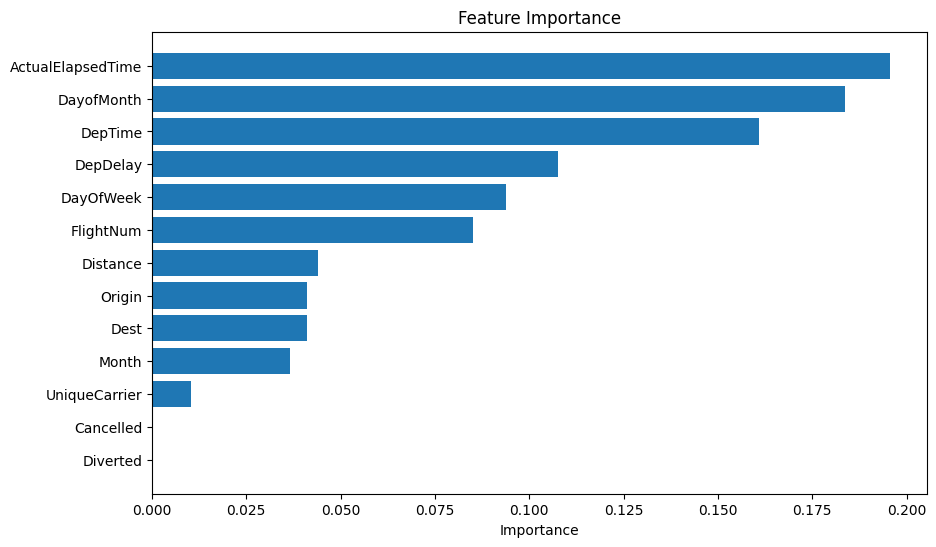

In [21]:
feature_importance_91 = analyze_model_features(model91, pdf91)

In [29]:
feature_importance_91.to_csv('feature_importance_91.csv')

              Feature  Importance
1             TailNum    0.132604
7             DepTime    0.121806
9   ActualElapsedTime    0.113906
5          DayofMonth    0.107875
13            TaxiOut    0.092043
10           DepDelay    0.088174
8           FlightNum    0.080924
12             TaxiIn    0.070915
6           DayOfWeek    0.056409
11           Distance    0.037958
2              Origin    0.036579
3                Dest    0.036291
4               Month    0.015496
0       UniqueCarrier    0.009020
14          Cancelled    0.000000
15           Diverted    0.000000


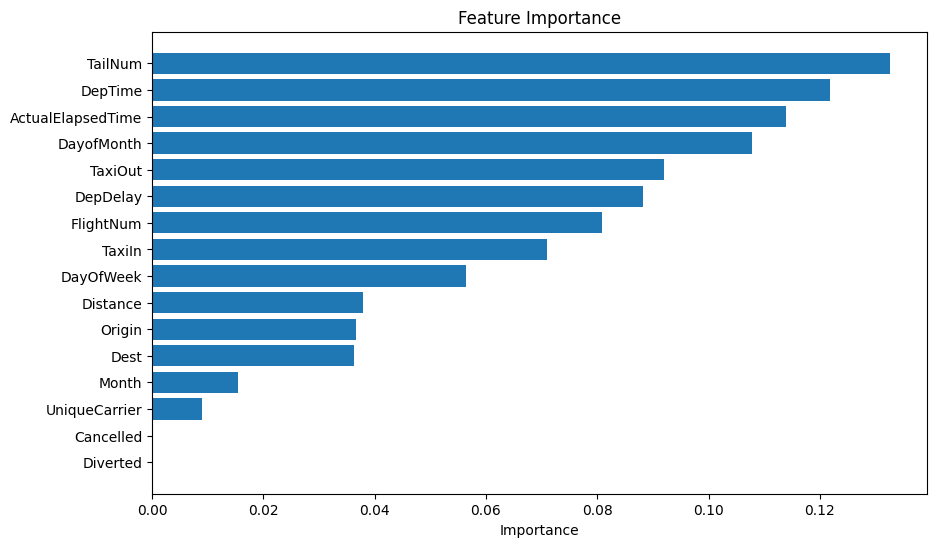

In [22]:
feature_importance_01 = analyze_model_features(model01, pdf01)

In [30]:
feature_importance_01.to_csv('feature_importance_01.csv')